In [1]:
from torchsr.models import ninasr_b0
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# Calculate pairwise distances between the 20 points in 1280-dimensional space
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances

import torchview
import seaborn as sns
import torch
import os
import random
from pathlib import Path


In [2]:
# Download a pretrained NinaSR model
model = ninasr_b0(scale=2, pretrained=True).cuda()
model.eval()
model

NinaSR(
  (head): Sequential(
    (0): Rescale()
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): AttentionBlock(
          (body): Sequential(
            (0): AvgPool2d(kernel_size=31, stride=16, padding=15)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
            (5): Upsample(scale_factor=16.0, mode='nearest')
          )
        )
        (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Attent

In [3]:
lr = Image.open("./cat.jpg")

# Run the Super-Resolution model
lr_t = to_tensor(lr).unsqueeze(0).cuda()
lr_t.shape

torch.Size([1, 3, 584, 612])

In [4]:
N = 50  # images per class
image_dir = Path("/home/insane/U/imagenette2-320/train")
classes = sorted(os.listdir(image_dir))  # sort to ensure consistent class order

total_classes = len(classes)

# First pass to calculate average dimensions
total_height = 0
total_width = 0
num_images = 0

for class_name in classes[:total_classes]:
    class_path = image_dir / class_name
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, N)
    
    for img_file in selected_files:
        img_path = class_path / img_file
        img = Image.open(img_path)
        width, height = img.size
        total_width += width
        total_height += height
        num_images += 1

target_width = int(total_width / num_images)
target_height = int(total_height / num_images)

# Second pass to load and resize images
all_images = []
for class_name in classes[:total_classes]:
    class_path = image_dir / class_name
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, N)
    
    for img_file in selected_files:
        img_path = class_path / img_file
        img = Image.open(img_path)
        # Convert to RGB in case some images are grayscale
        img = img.convert('RGB')
        # Resize to average dimensions
        img = img.resize((target_width, target_height))
        # Convert to tensor and add to list
        img_tensor = to_tensor(img)
        all_images.append(img_tensor)

# Stack all images into a single tensor
dataset = torch.stack(all_images).cuda()
print(f"Dataset shape: {dataset.shape}")  # Should be [N*10, 3, target_height, target_width]


Dataset shape: torch.Size([500, 3, 347, 413])


In [5]:
torchview.draw_graph(
    model,
    input_data=lr_t,
    expand_nested=False,
    hide_module_functions=False,
    hide_inner_tensors=True,
    roll=False,
    device="cuda",
    save_graph=True,
    depth=2,
    directory="models-pdf"
)


In [6]:
layers_to_hook = [
    model.body[0].body[2].body[3],
    model.body[2].body[2].body[3],
    model.body[4].body[2].body[3],
    model.body[6].body[2].body[3],
    model.body[8].body[2].body[3],
]

layer_outputs = [[] for _ in layers_to_hook]

def hook_fn(layer_idx):
    def hook(module, grad_input, grad_output):
        layer_outputs[layer_idx].append(grad_output.detach().cpu().numpy())
    return hook

hooks = [layer.register_forward_hook(hook_fn(i)) for i, layer in enumerate(layers_to_hook)]

# Process in batches of 4 images
batch_size = 10
num_batches = len(dataset) // batch_size + (1 if len(dataset) % batch_size != 0 else 0)

sr_outputs = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(dataset))
    batch = dataset[start_idx:end_idx]
    
    with torch.no_grad():  # Add this to save memory
        sr_batch = model(batch)
        sr_outputs.append(sr_batch.cpu())

sr_t = torch.cat(sr_outputs, dim=0)
print(f"sr_t: {sr_t.shape}")

for hook in hooks:
    hook.remove()

layer_outputs = [np.array(output) for output in layer_outputs]
layer_outputs = [output.reshape((-1,) + output.shape[2:]) for output in layer_outputs]

for i, output in enumerate(layer_outputs):
    print(f"layer_output {i}: {output.shape}")

100%|██████████| 50/50 [00:04<00:00, 12.39it/s]


sr_t: torch.Size([500, 3, 694, 826])
layer_output 0: (500, 32, 22, 26)
layer_output 1: (500, 32, 22, 26)
layer_output 2: (500, 32, 22, 26)
layer_output 3: (500, 32, 22, 26)
layer_output 4: (500, 32, 22, 26)


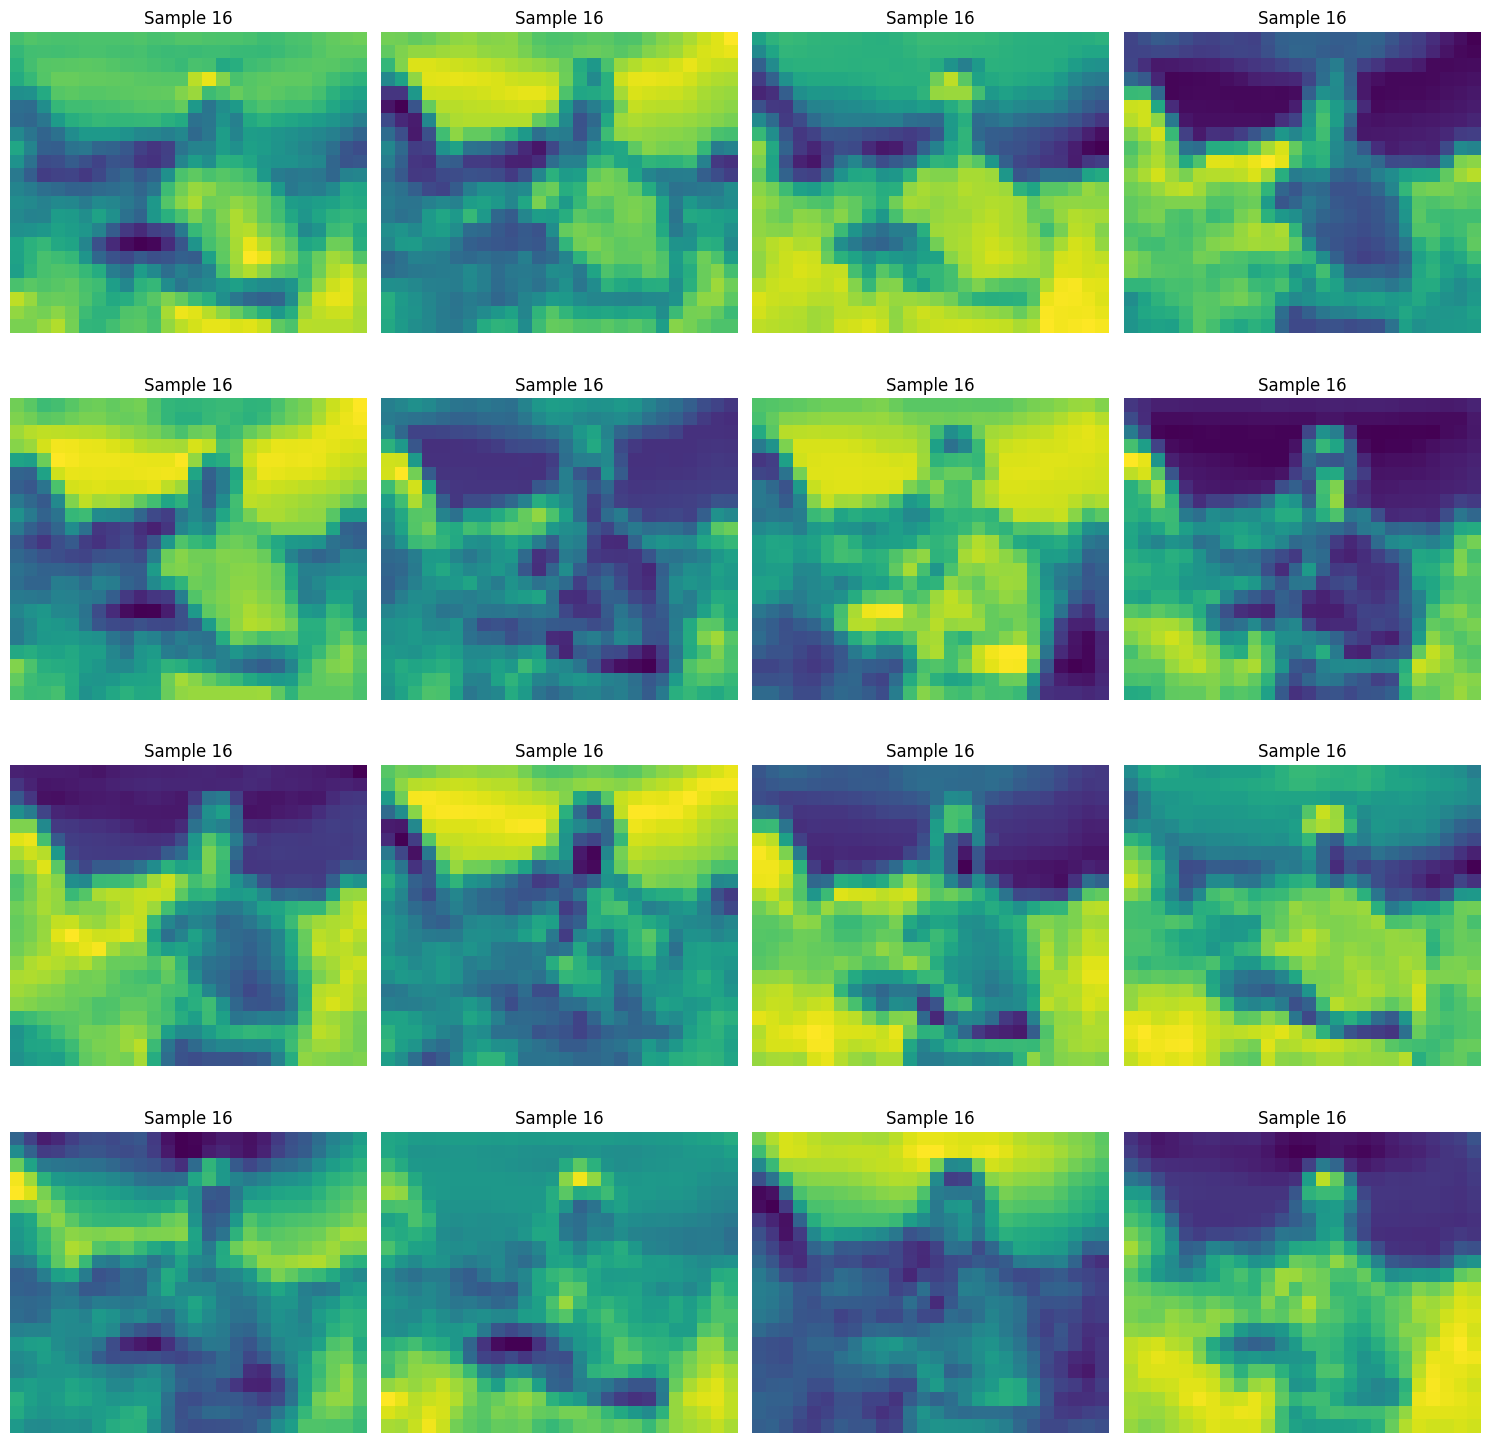

In [7]:
layer_output = layer_outputs[0]
num_samples = min(16, len(layer_output))  # Show up to 16 samples
grid_size = int(np.ceil(np.sqrt(num_samples)))  # Calculate grid dimensions based on num_samples
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

for sample_idx in range(num_samples):
    layer_output_to_show = layer_output[sample_idx]
    
    for i in range(len(layer_output_to_show)):
        row = i // grid_size
        col = i % grid_size
        if row < grid_size and col < grid_size:  # Check if within grid bounds
            axes[row, col].imshow(layer_output_to_show[i], cmap='viridis')
            axes[row, col].axis('off')
            axes[row, col].set_title(f'Sample {sample_idx+1}')

# Hide empty subplots
for i in range(grid_size):
    for j in range(grid_size):
        if i * grid_size + j >= num_samples:
            axes[i,j].axis('off')

plt.tight_layout()
plt.show()


In [11]:
channel_norms = [torch.norm(torch.tensor(layer_outputs[i]), p=2, dim=(2,3)) for i in range(len(layer_outputs))]  # Results in [20, 1280]
# Convert channel norms to numpy array for MDS
channel_norms_np = [channel_norm.cpu().numpy() for channel_norm in channel_norms]
for channel_norm in channel_norms_np:
    print(f"channel_norm: {channel_norm.shape}")


channel_norm: (500, 32)
channel_norm: (500, 32)
channel_norm: (500, 32)
channel_norm: (500, 32)
channel_norm: (500, 32)


/tmp/ipykernel_647360/1452352683.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[layer_idx].scatter(mds_coords[i*N:(i+1)*N, 0],
/tmp/ipykernel_647360/1452352683.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[layer_idx].scatter(mds_coords[i*N:(i+1)*N, 0],
/tmp/ipykernel_647360/1452352683.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-map

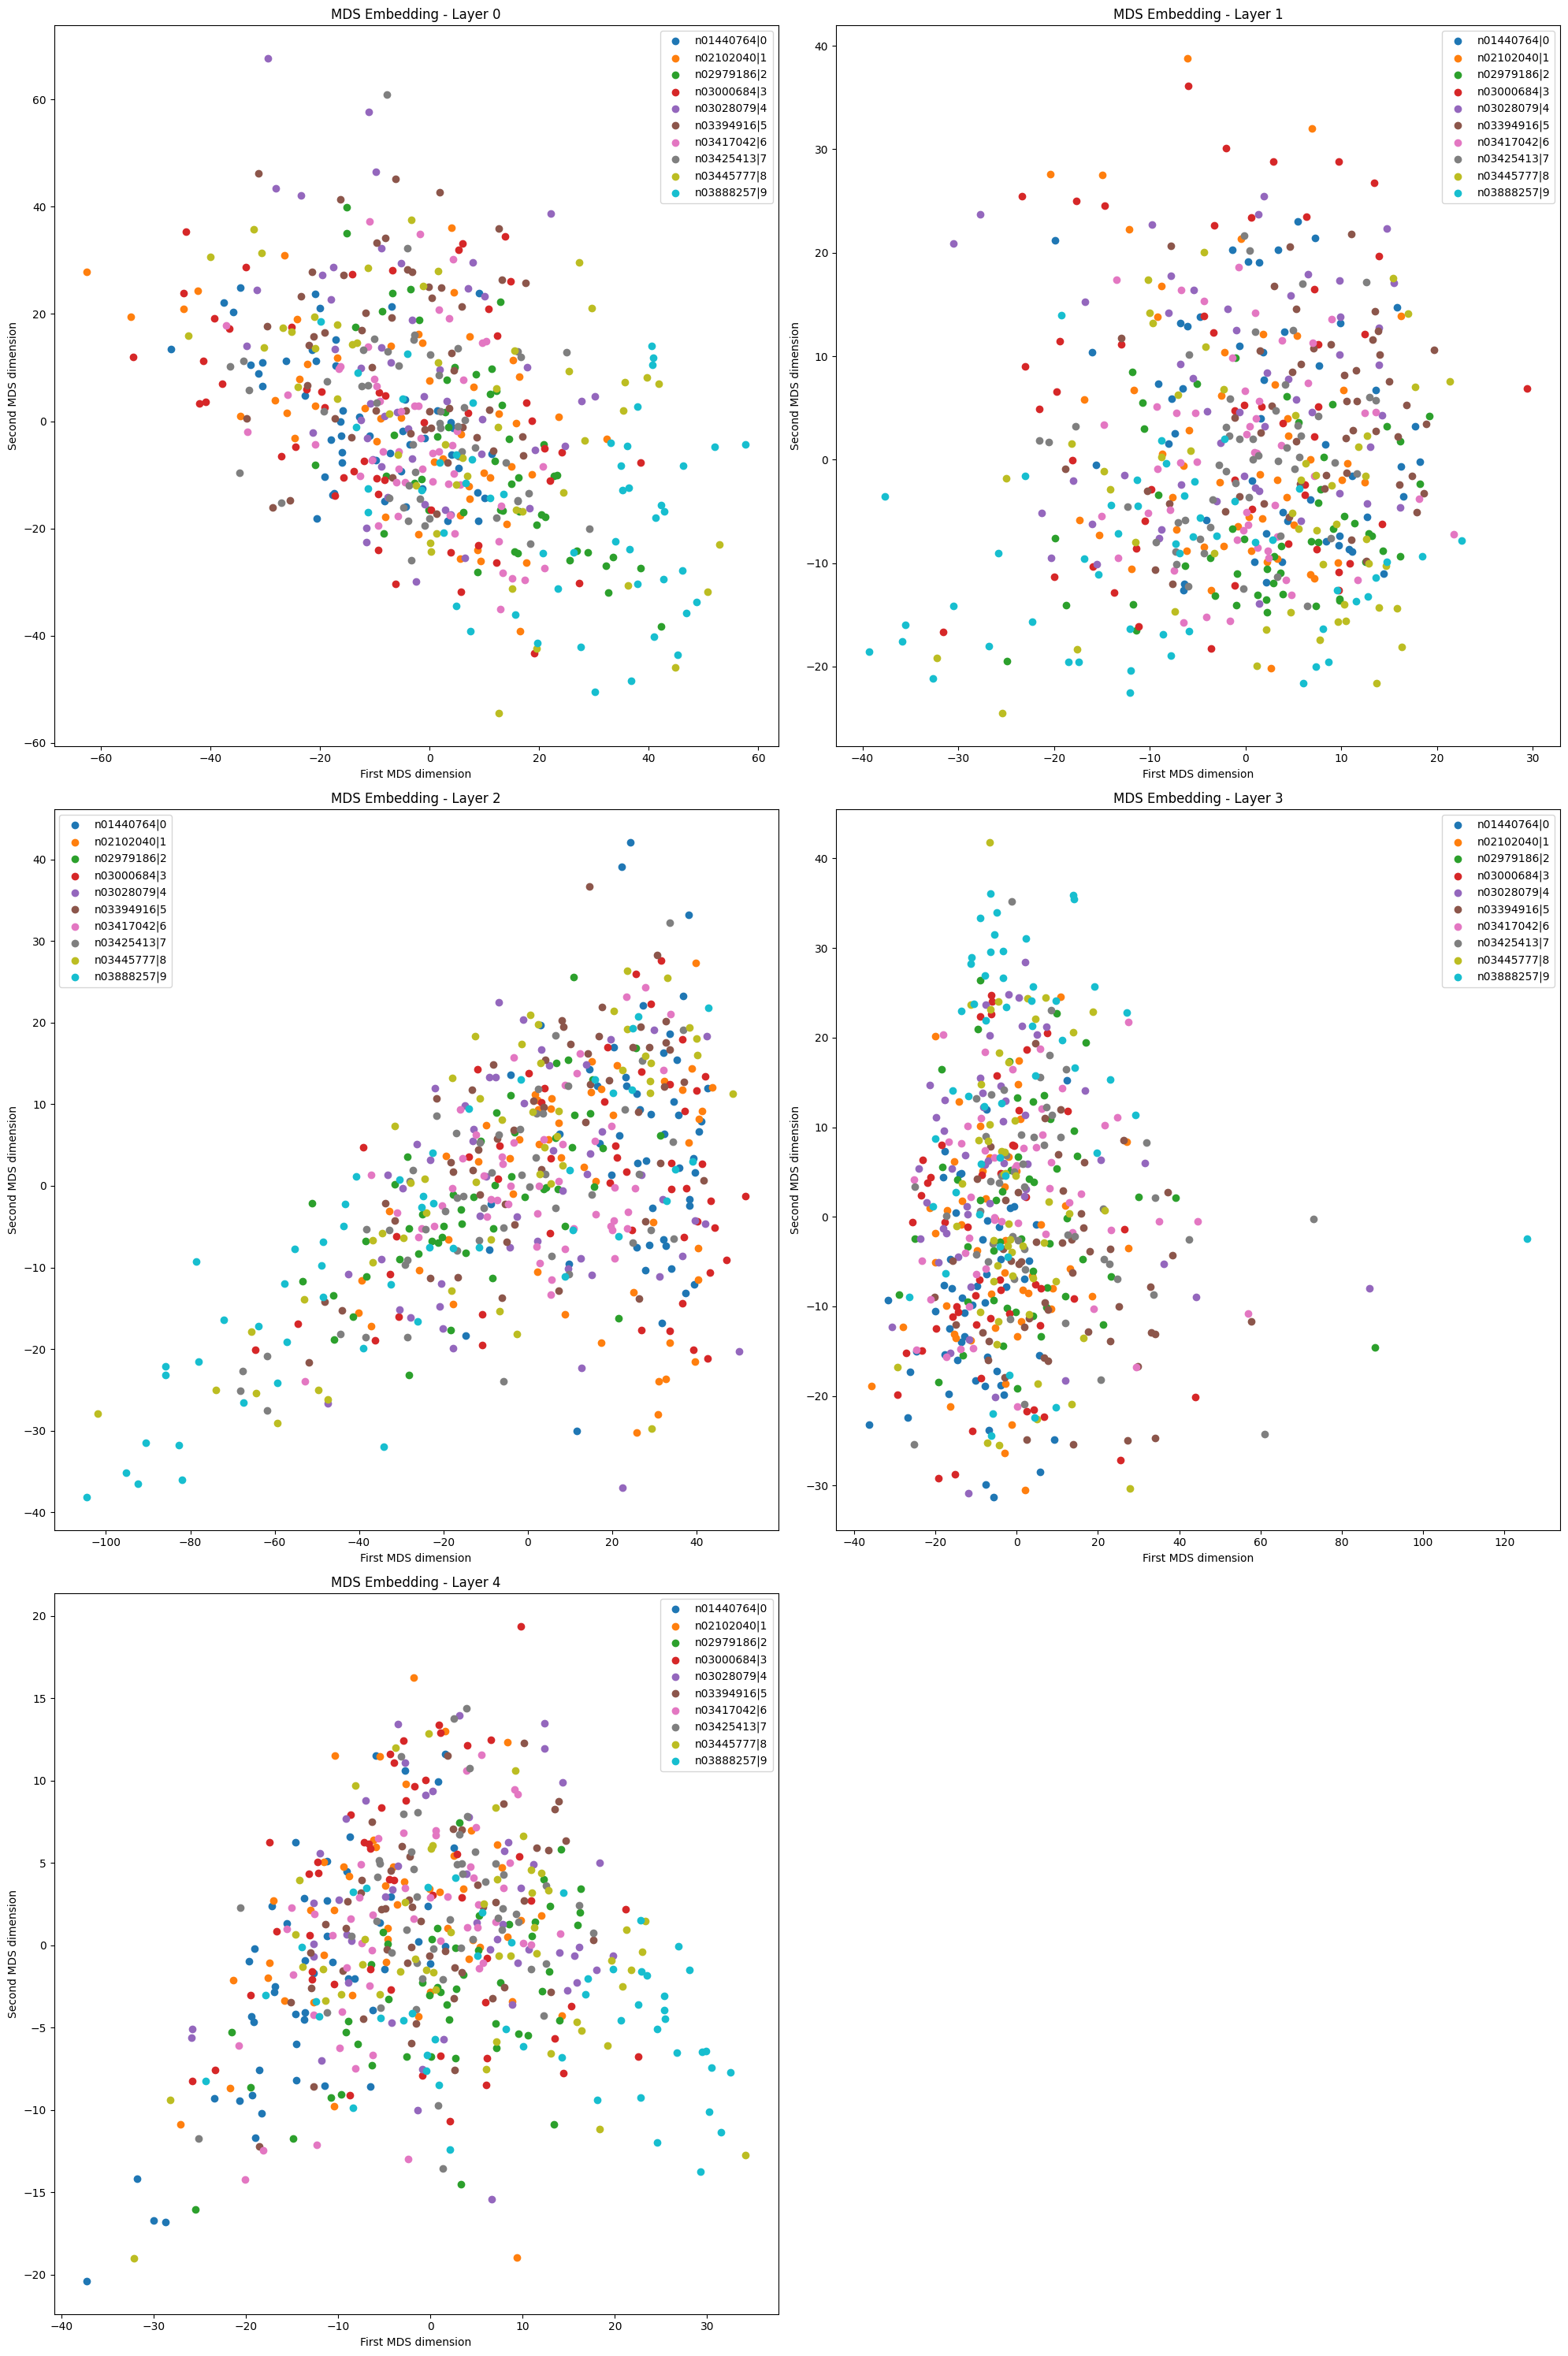

In [12]:
# Create MDS objects and fit the data for each channel norm
n_layers = len(channel_norms_np)
n_rows = int(np.ceil(np.sqrt(n_layers)))
n_cols = int(np.ceil(n_layers / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))
axes = axes.ravel()

total_classes = 10
colors = [plt.cm.tab10(i) for i in range(total_classes)]
labels = classes[:total_classes]

for layer_idx, channel_norm in enumerate(channel_norms_np):
    # Create MDS embedding for this layer
    mds = MDS(n_components=2, random_state=42)
    mds_coords = mds.fit_transform(channel_norm)
    
    # Plot the MDS embedding for this layer
    for i, (color, label) in enumerate(zip(colors, labels)):
        axes[layer_idx].scatter(mds_coords[i*N:(i+1)*N, 0],
                               mds_coords[i*N:(i+1)*N, 1],
                               c=color, label=f"{label}|{i}")
    
    axes[layer_idx].set_title(f'MDS Embedding - Layer {layer_idx}')
    axes[layer_idx].set_xlabel('First MDS dimension')
    axes[layer_idx].set_ylabel('Second MDS dimension')
    axes[layer_idx].legend()

# Hide empty subplots if any
for idx in range(n_layers, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_618794/3286014976.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[idx].scatter(tsne_coords[i*N:(i+1)*N, 0],
/tmp/ipykernel_618794/3286014976.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[idx].scatter(tsne_coords[i*N:(i+1)*N, 0],
/tmp/ipykernel_618794/3286014976.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will 

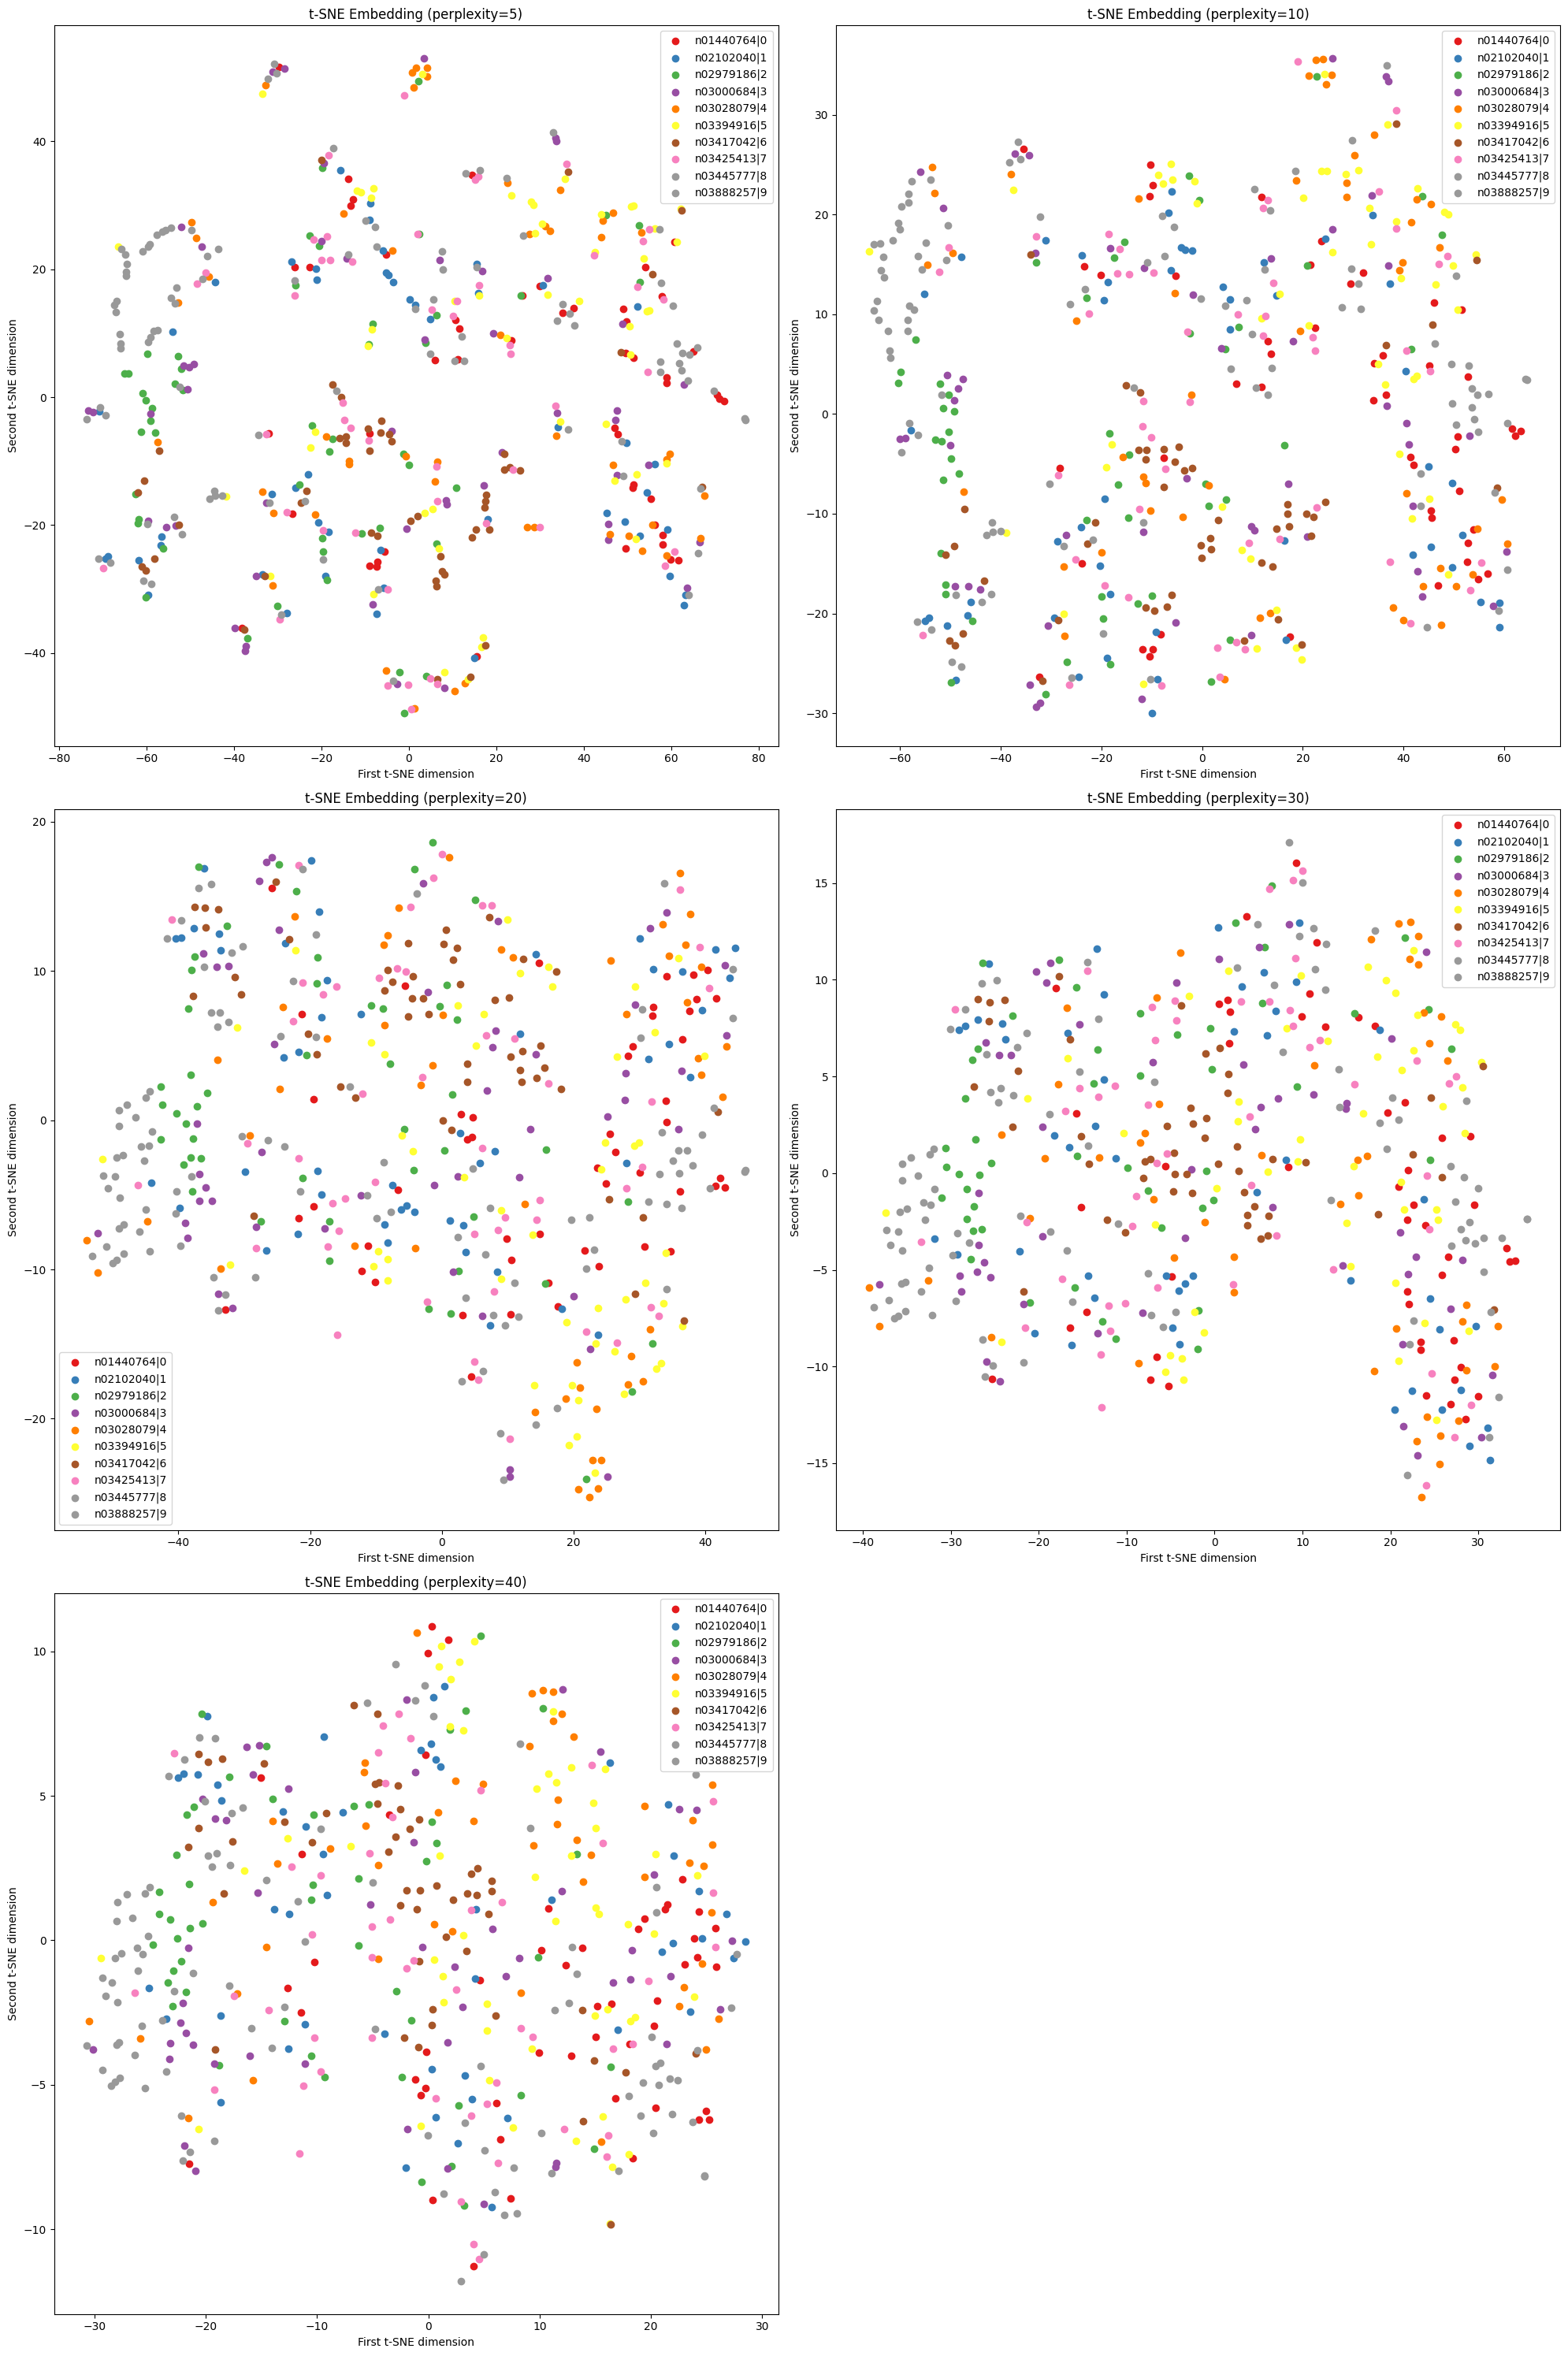

In [14]:
# Create t-SNE embeddings with different perplexities
perplexities = [5, 10, 20, 30, 40]
n_plots = len(perplexities)
n_rows = int(np.ceil(np.sqrt(n_plots)))
n_cols = int(np.ceil(n_plots / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))
axes = axes.ravel()

total_classes = 10
colors = [plt.cm.Set1(i) for i in range(total_classes)]  # Using Set1 colormap instead of tab10
labels = classes[:total_classes]

for idx, perp in enumerate(perplexities):
    # Create t-SNE object and fit the data
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
    tsne_coords = tsne.fit_transform(channel_norms_np)
    
    for i, (color, label) in enumerate(zip(colors, labels)):
        # if i in [4, 5, 1,2 , 7]:
        #     continue
        # print(f"Perplexity {perp}, i: {i}, label: {label}, num_points: {tsne_coords[i*N:(i+1)*N, 0].shape}")
        axes[idx].scatter(tsne_coords[i*N:(i+1)*N, 0],
                         tsne_coords[i*N:(i+1)*N, 1],
                         c=color, label=f"{label}|{i}")
    
    axes[idx].set_title(f't-SNE Embedding (perplexity={perp})')
    axes[idx].set_xlabel('First t-SNE dimension')
    axes[idx].set_ylabel('Second t-SNE dimension')
    axes[idx].legend()

# Hide empty subplots if any
for idx in range(len(perplexities), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


/home/insane/.pyenv/versions/srgan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/insane/.pyenv/versions/srgan/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


i: 0, label: n01440764, num_points: (50,)
i: 1, label: n02102040, num_points: (50,)
i: 2, label: n02979186, num_points: (50,)
i: 3, label: n03000684, num_points: (50,)
i: 8, label: n03445777, num_points: (50,)
i: 9, label: n03888257, num_points: (50,)


/tmp/ipykernel_618794/2061788223.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_coords[i*N:(i+1)*N, 0],


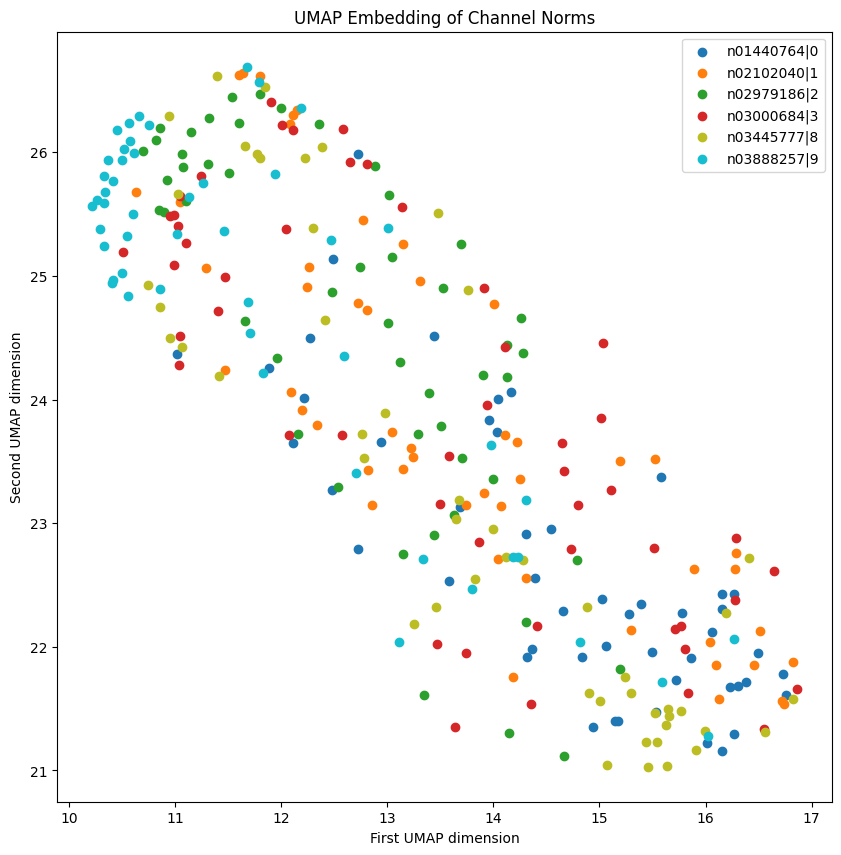

In [11]:
# Create UMAP object and fit the data
import umap
umap_reducer = umap.UMAP(n_neighbors=400, random_state=42)
umap_coords = umap_reducer.fit_transform(channel_norms_np)

total_classes = 10

colors = [plt.cm.tab10(i) for i in range(total_classes)]
labels = classes[:total_classes]

# Plot the UMAP embedding
plt.figure(figsize=(10, 10))

for i, (color, label) in enumerate(zip(colors, labels)):
    if i in [5, 4, 7, 6]:
        continue
    print(f"i: {i}, label: {label}, num_points: {umap_coords[i*N:(i+1)*N, 0].shape}")
    plt.scatter(umap_coords[i*N:(i+1)*N, 0], 
                umap_coords[i*N:(i+1)*N, 1], 
                c=color, label=f"{label}|{i}")

plt.title('UMAP Embedding of Channel Norms')
plt.xlabel('First UMAP dimension')
plt.ylabel('Second UMAP dimension')
plt.legend()

plt.show()


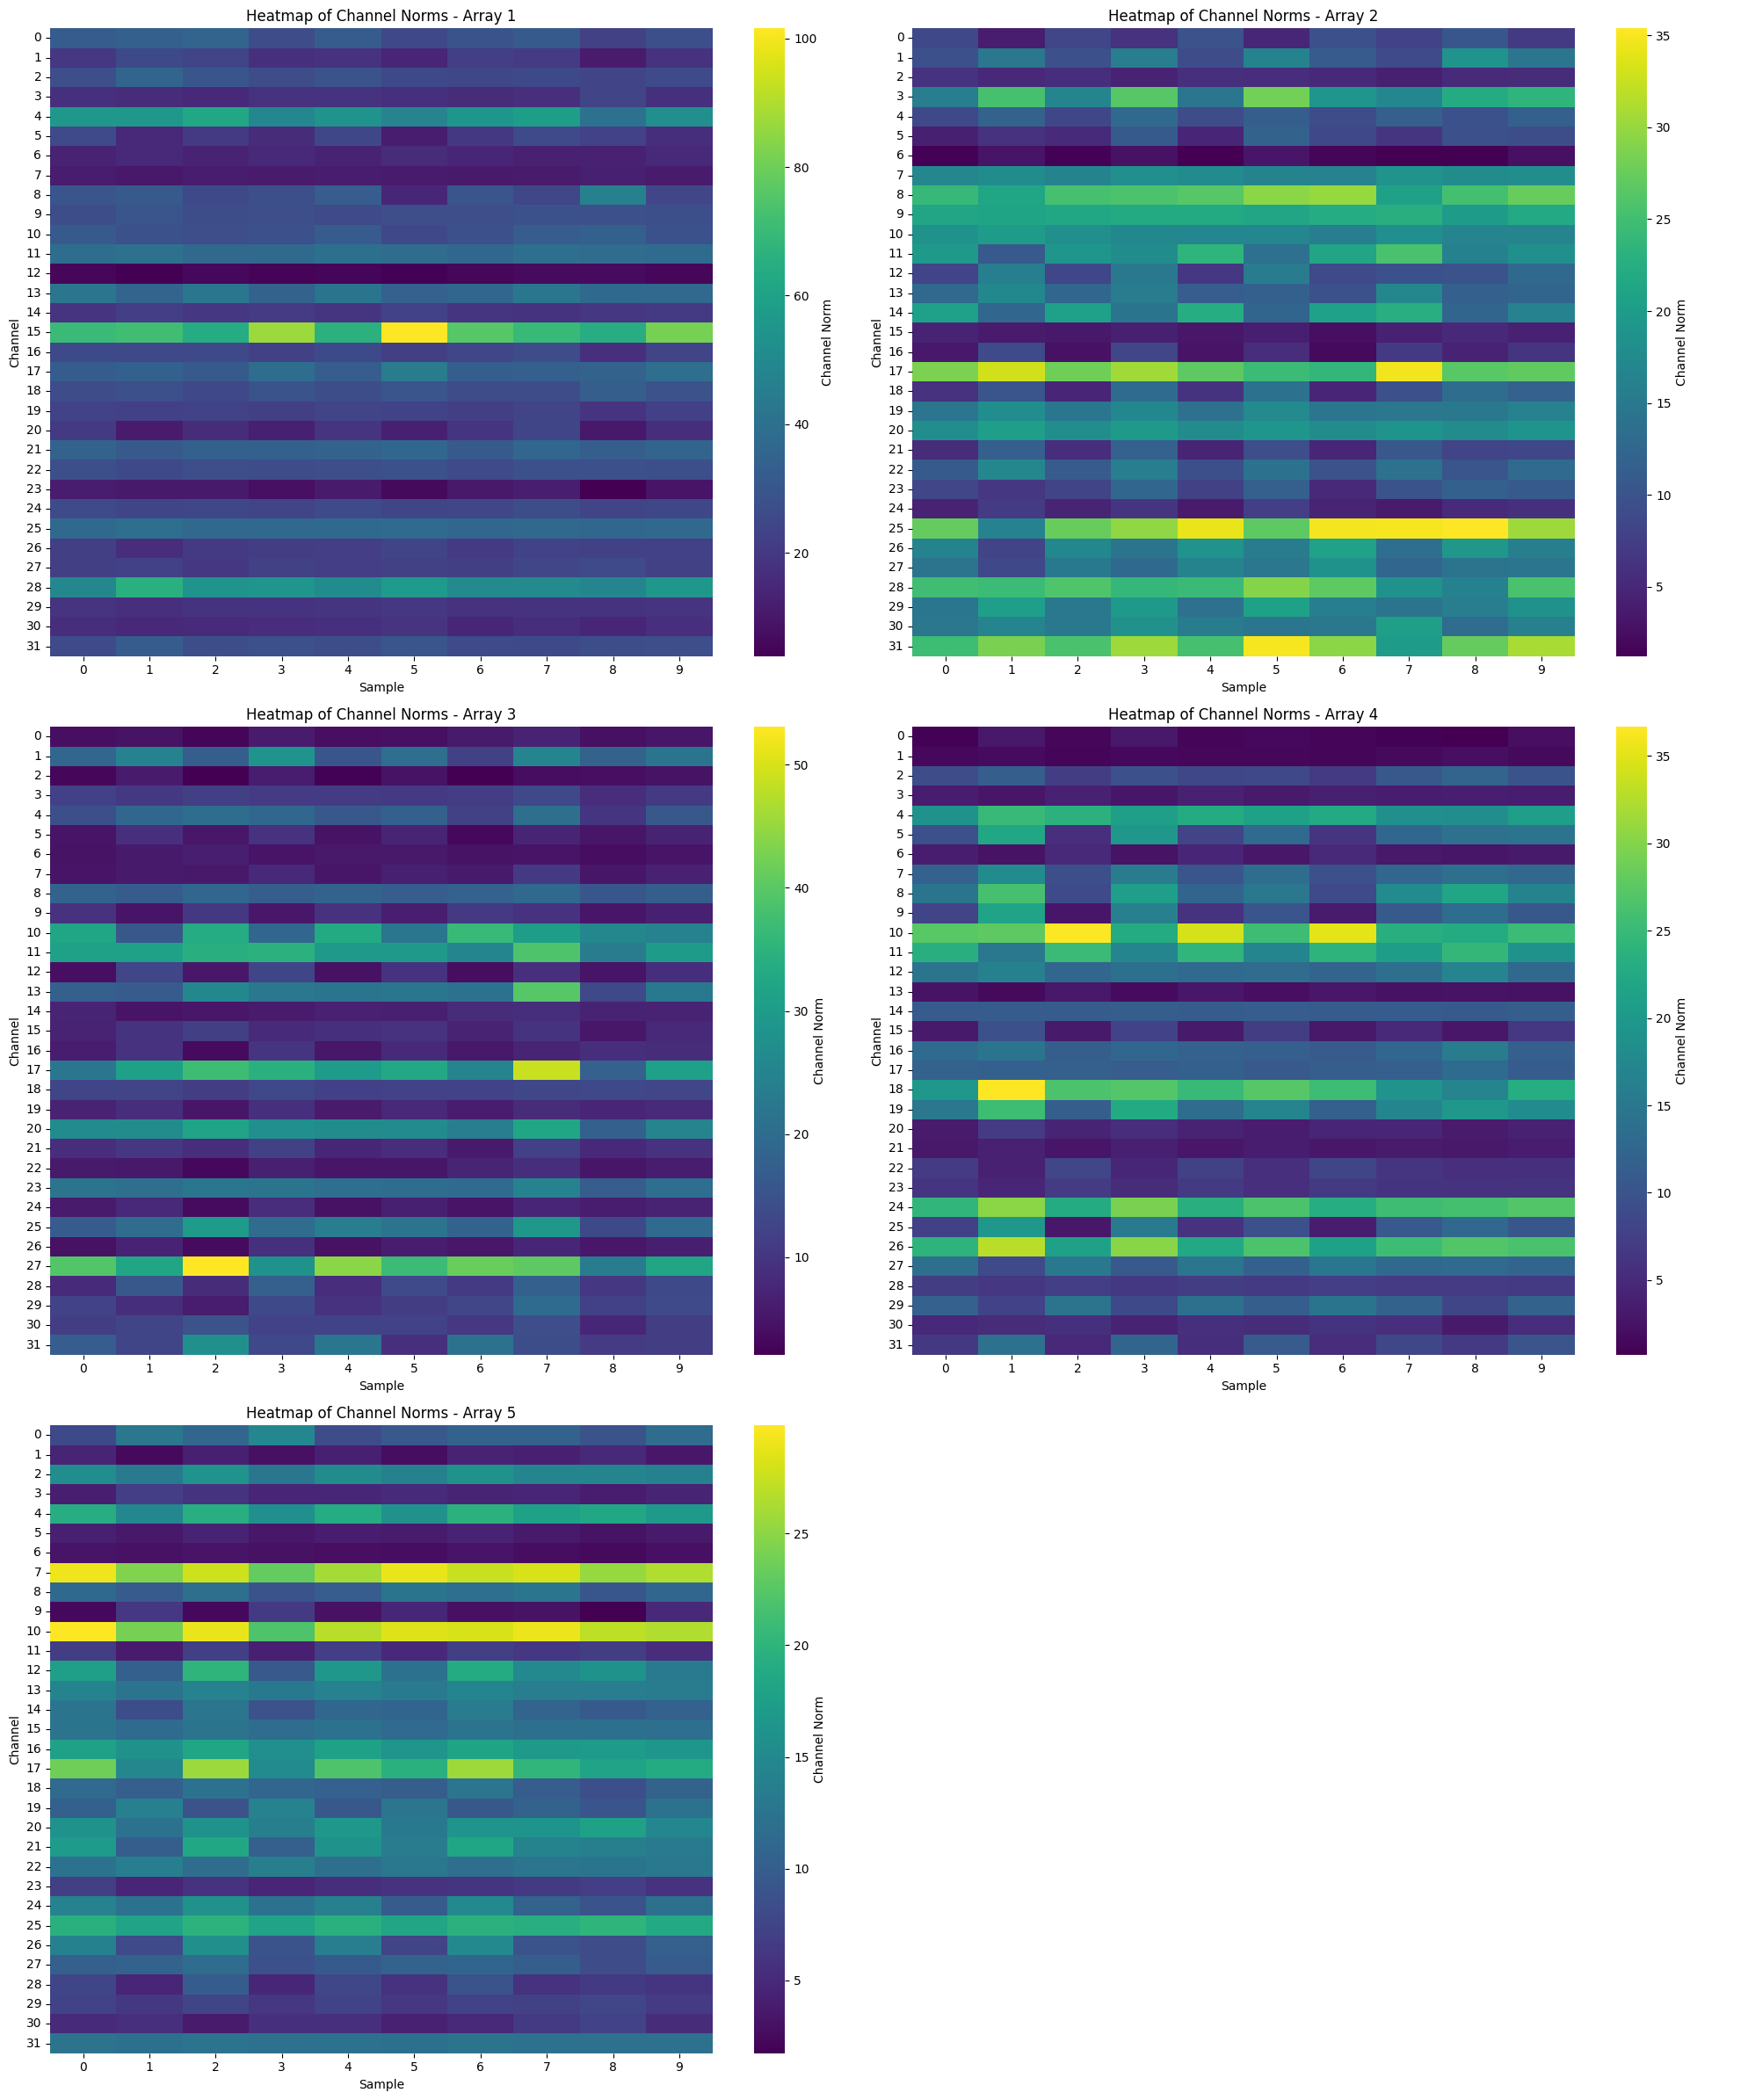

In [16]:
n_samples_per_class = 10
sampled_channel_norms = []

# Create a grid of heatmaps
n_rows = len(channel_norms_np) // 2 + len(channel_norms_np) % 2
fig, axes = plt.subplots(n_rows, 2, figsize=(20, 8*n_rows))
axes = axes.flatten()

for i, norms in enumerate(channel_norms_np):
    # Sample n points from this array
    samples = norms[0:n_samples_per_class]
    sampled_channel_norms.append(samples)
    
    # Create heatmap for this array
    sns.heatmap(samples.transpose(), cmap='viridis', 
                cbar_kws={'label': 'Channel Norm'},
                ax=axes[i])
    axes[i].set_title(f'Heatmap of Channel Norms - Array {i+1}')
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel('Channel')

# Hide empty subplots if any
for idx in range(len(channel_norms_np), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


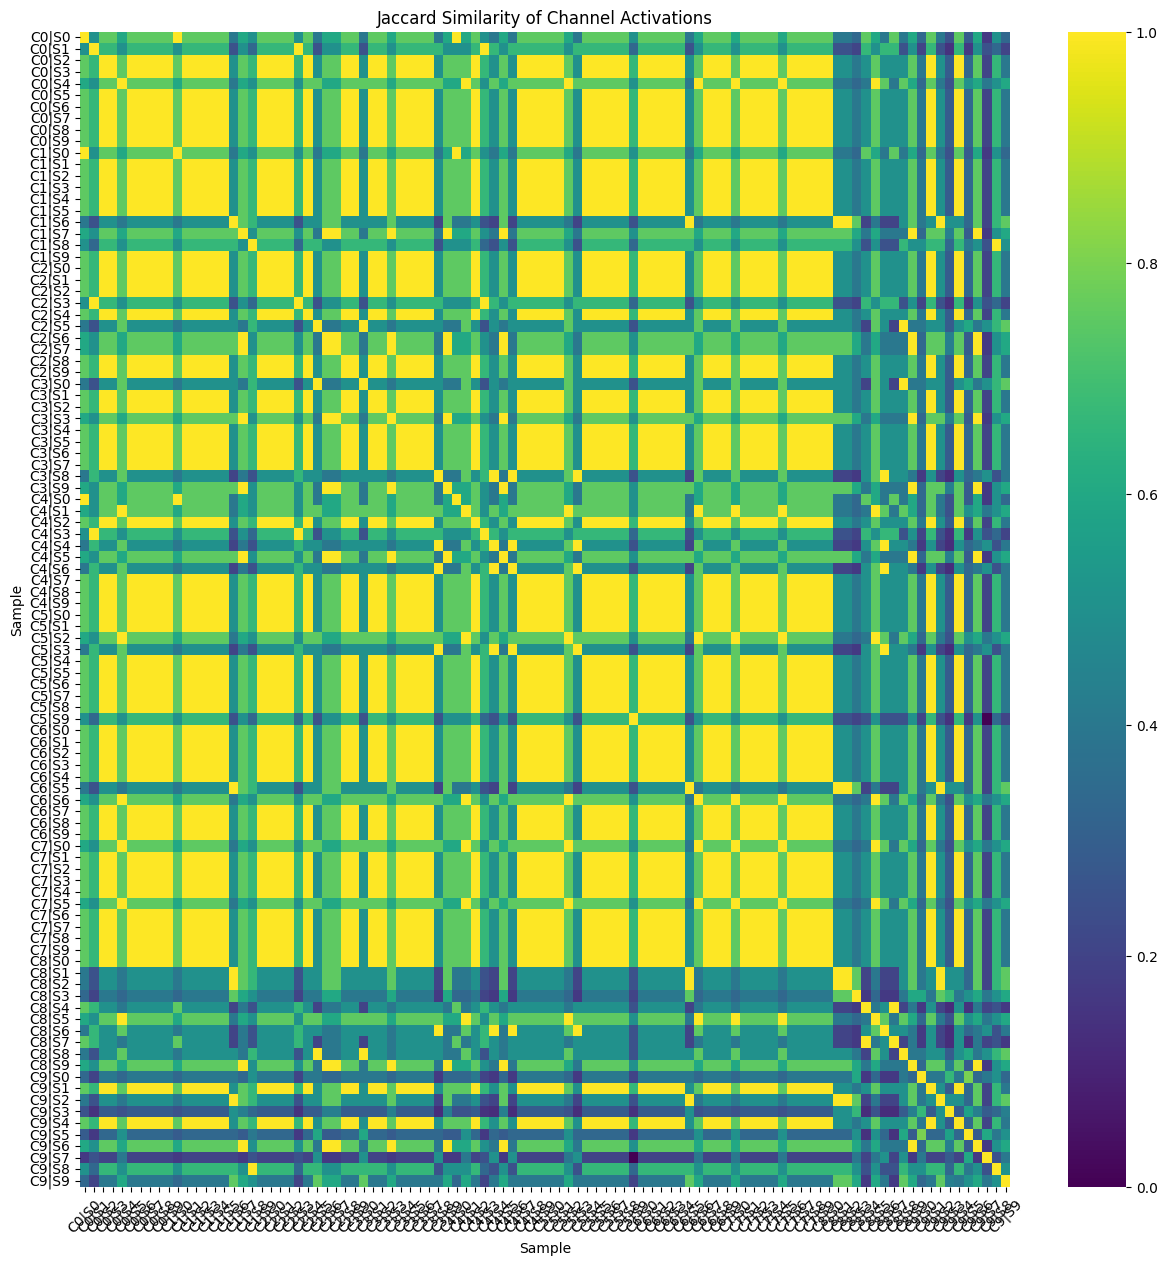

In [20]:
# Calculate threshold at 40th percentile
threshold = np.percentile(sampled_channel_norms, 90)

# Create binary activation matrix (1 if above threshold, 0 if below)
activations = (sampled_channel_norms > threshold).astype(int)

# Calculate Jaccard similarity matrix
n_samples = activations.shape[0]
jaccard_matrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(n_samples):
        intersection = np.sum(np.logical_and(activations[i], activations[j]))
        union = np.sum(np.logical_or(activations[i], activations[j]))
        jaccard_matrix[i,j] = intersection / union if union > 0 else 0

# Plot Jaccard similarity heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_matrix, cmap='viridis', 
            xticklabels=[f'C{i//n_samples_per_class}|S{i%n_samples_per_class}' for i in range(n_samples)],
            yticklabels=[f'C{i//n_samples_per_class}|S{i%n_samples_per_class}' for i in range(n_samples)])
plt.title('Jaccard Similarity of Channel Activations')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


input_images: (100, 3, 347, 413)


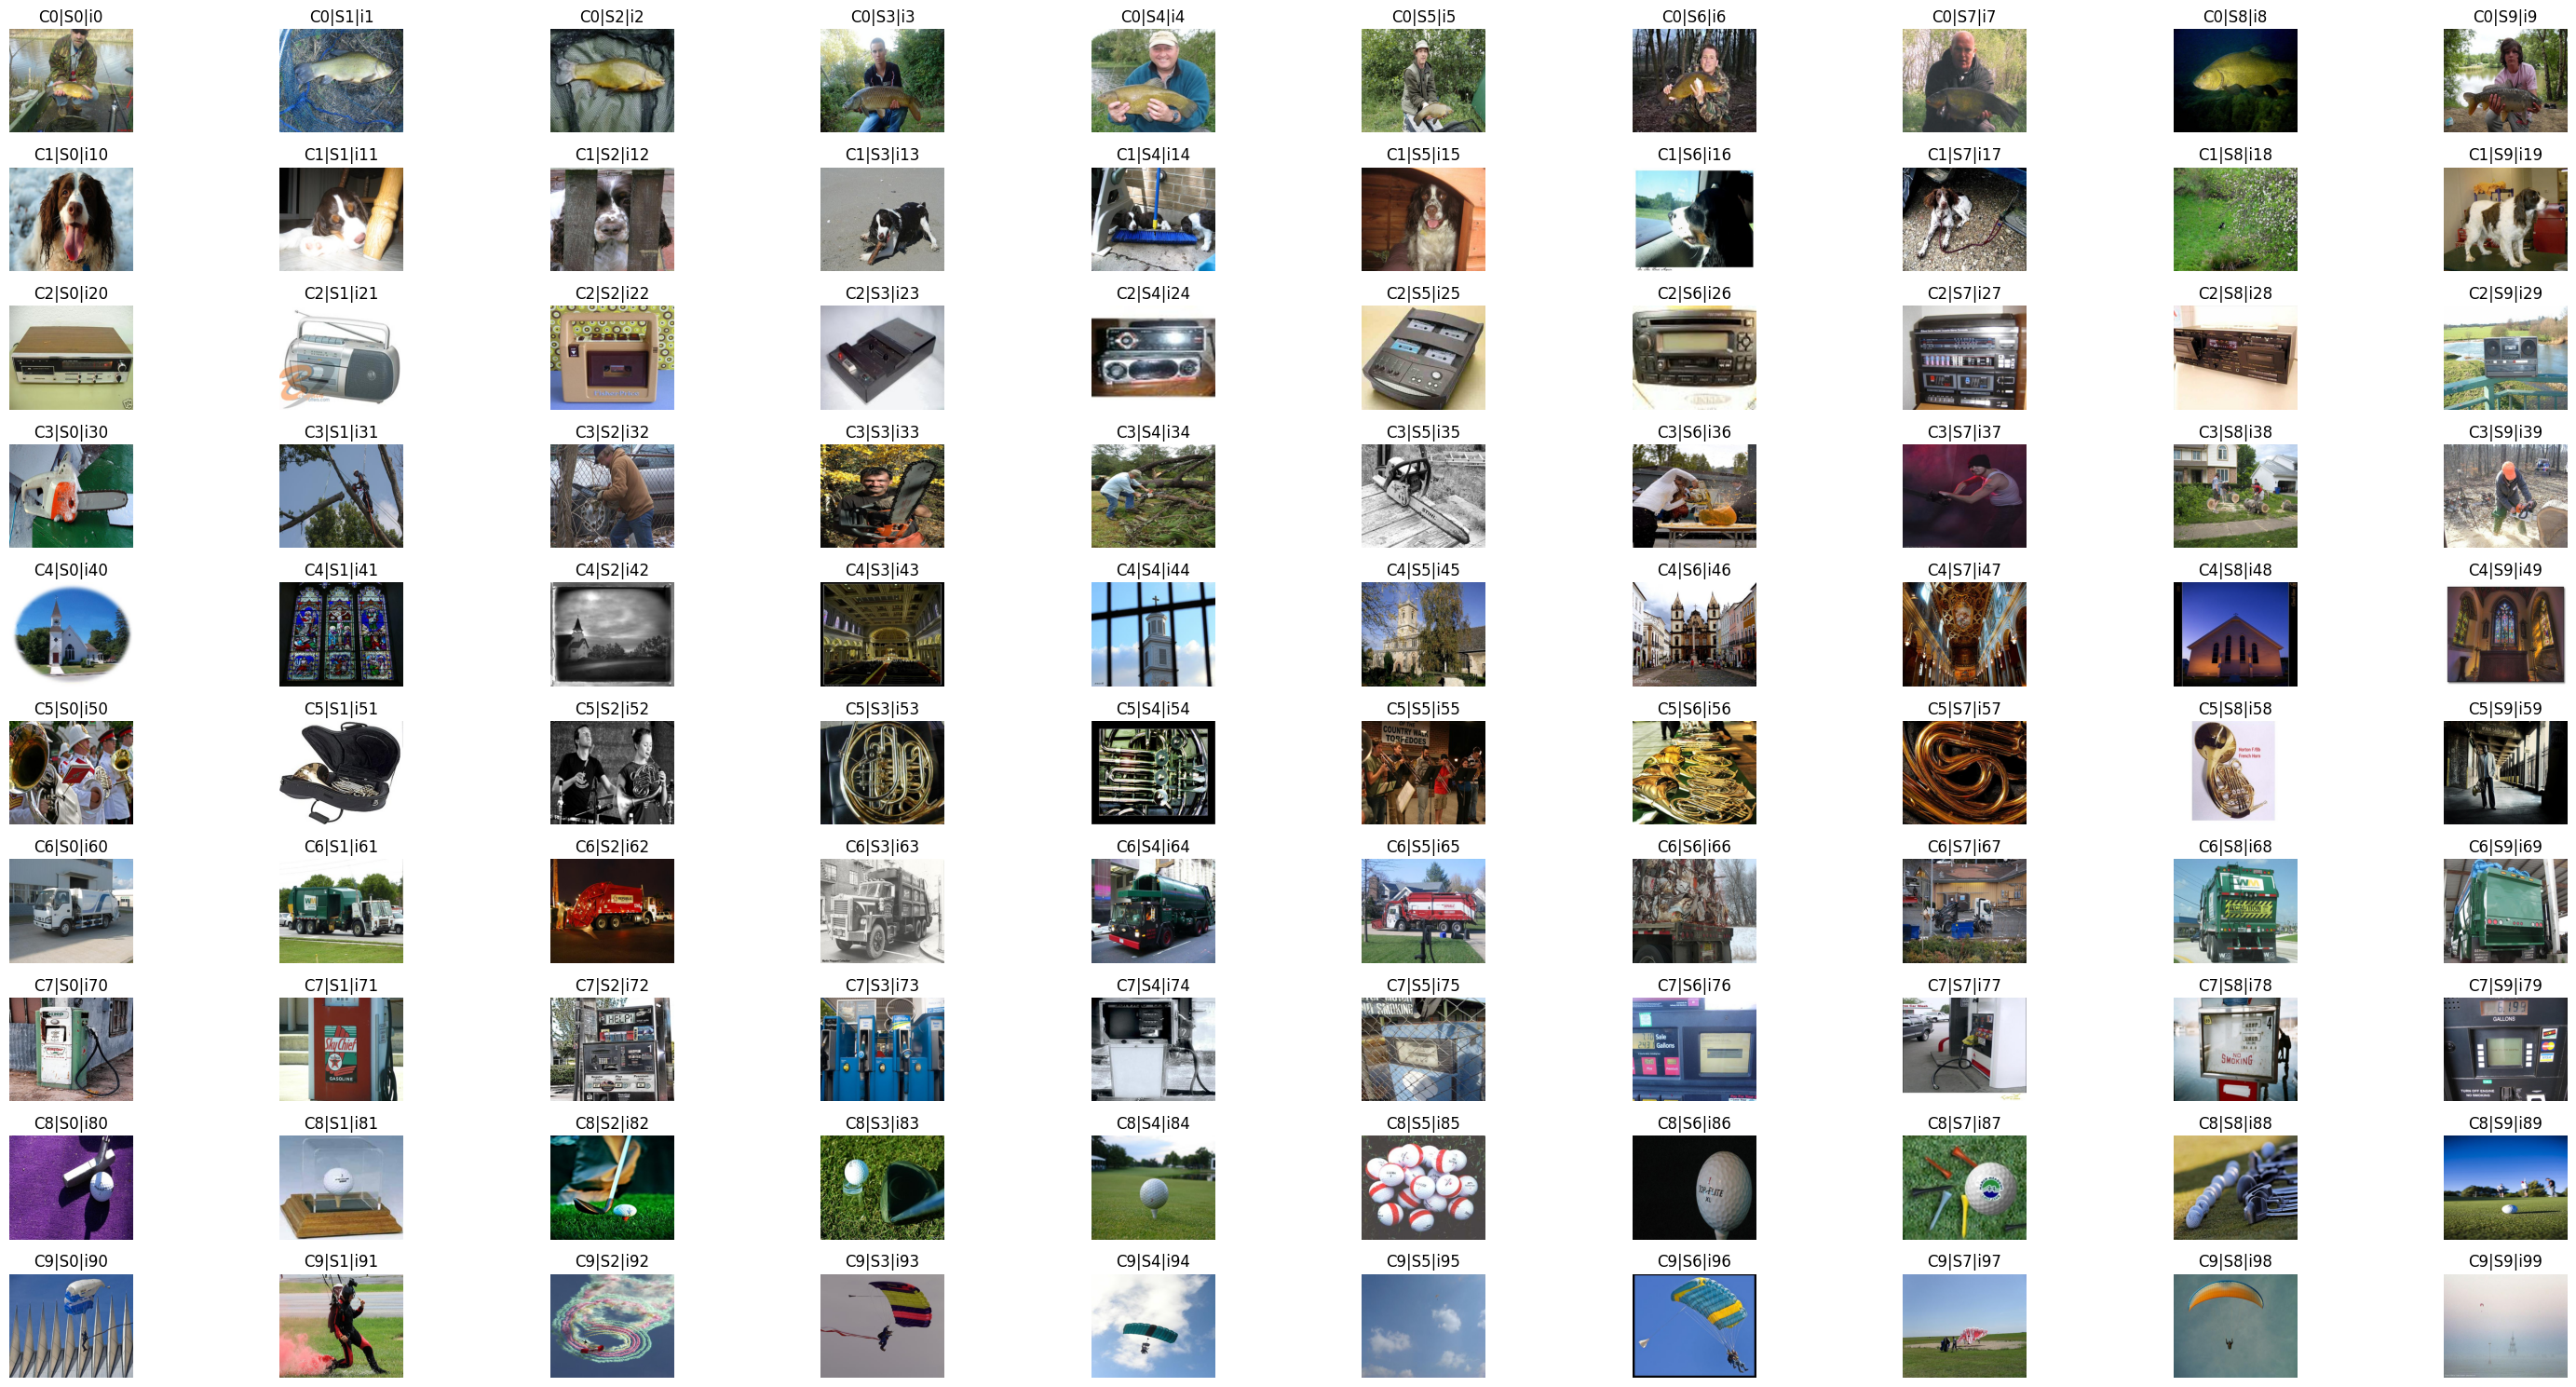

In [17]:
input_images = []
for i in range(total_classes):
    input_images.append(dataset[i*N:i*N + n_samples_per_class].cpu().numpy())
    
# Reshape to [N, 3, H, W]
input_images = np.array(input_images).reshape(-1, input_images[0].shape[-3], input_images[0].shape[-2], input_images[0].shape[-1])
print(f"input_images: {input_images.shape}")

# Create a grid of input images
plt.figure(figsize=(30, 15))

n_rows = total_classes
n_cols = n_samples_per_class
for i in range(total_classes):
    for j in range(n_samples_per_class):
        sample_idx = i*n_samples_per_class + j
        plt.subplot(n_rows, n_cols, sample_idx + 1)
        plt.imshow(np.transpose(input_images[sample_idx], (1, 2, 0)))
        plt.axis('off')
        plt.title(f'C{i}|S{j}|i{sample_idx}')
plt.tight_layout()
